## This processes the text data 
In this code I process the text and make sure everything is all good
<br>
In report dcc 1st 'DCC shares climb 35% as Jefferies reaffirms buy rating' links with the second part 

Use the price at the opening of the stock market of that day as a starting point to make the target then use the close of the next day or of a delay to make the target price. This will be varied to as the lag time between an article being published and the result price change is unkown

I need to over sample the lower fequency sentence/ adjust ratings 

<br>

I also need to split the data 80-20 in the last bit of code as this will prevent knolage of the future bias

In [499]:
import re 
import datetime
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer


from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

stop_words = set(stopwords.words('english'))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


In [500]:
file = open('text.csv','r',encoding='UTF-8')
File = open('stocks_name.txt','r')

Name = []
Codes = []
Type = []

for line in File:
    line = re.sub('\n', '', line)
    line = line.split('\t')
    Name.append(re.sub(' ', '-',line[0].lower()))
    Type.append(line[2])
    if line[1][2:4] == '.A':
        Codes.append('BT-A.L')
    elif line[1][2] == '.':
        Codes.append(line[1] + 'L')
    else:
        Codes.append(line[1] + '.L')

a=0
le = 0
for line in file:
    line = line.split(']')
    #print(line)
    #print(len(line))
    a+=len(line)
    le += 1
    if le == 3:
        h = line

print(le)
    
print('Total number of articles : ', a)

100
Total number of articles :  48758


In [501]:
sentence = []
date = []
a=0
for i in h:
    i = i.split('xa0')
    a+=1
    s=re.sub(r'-', ' ',i[0].lower())
    s=re.sub(r'()[a-z0-9]*@[a-z0-9]*','',s)
    s=re.sub(r'[^a-z0-9 ]', '', s)
    words = s.split()
    words = [word for word in words if word not in stop_words] #removes stop words
    content = ' '.join([lemmatizer.lemmatize(word) for word in words]) #reduces every word to its stem
    sentence.append(content)
    
    try:
        dat = re.sub(r'[^A-Za-z0-9 ]', '', i[-1])
        dat = re.sub(' ', '-', dat)
        dat = datetime.datetime.strptime(dat, '%b-%d-%Y')
        date.append(dat)
    except:
        dat = '27-03-2020'
        dat = datetime.datetime.strptime(dat, '%d-%m-%Y')
        date.append(dat)

print(len(sentence),len(date))
sentence = sentence[:-2]
date = date[:-2]
print(len(sentence),len(date))


1147 1147
1145 1145


In [502]:
print(Codes[2])

AAL.L


In [503]:
dF = pd.DataFrame(date)
dF.columns = ['Date']
dF['sent'] = sentence
dF = dF.sort_values('Date')
dF.set_index('Date', inplace=True)
dF.tail()


,sent
Date,
2020-03-19,today market view anglo american arc mineral a...
2020-03-24,mixed message south africa miner 21 day lockdo...
2020-03-24,uk share join global rebound stimulus measure
2020-03-27,today market view anglo american feedback plc ...
2020-03-27,anglo american see production hit south africa...


In [504]:
DF = pd.read_csv('csv/AAL.L.csv')

# Sort DataFrame by date
DF = DF.sort_values('Date')
DF.set_index('Date', inplace=True)

delay = 1
percent = []
for i in range(len(DF['Close'])-delay):
    percent.append((DF['Close'][i+delay] - DF['Open'][i])/DF['Open'][i])
    
for i in range(len(DF['Close'])-len(percent)):
    percent.append(0)
        
DF['percent'] = percent

DF.tail()

,Open,High,Low,Close,Adj Close,Volume,percent
Date,,,,,,,
2020-03-25,1351.800049,1434.900024,1309.800049,1390.400024,1390.400024,6991924,0.032697
2020-03-26,1319.800049,1400.800049,1312.599976,1396.000000,1396.000000,4584755,0.024398
2020-03-27,1344.800049,1376.199951,1307.800049,1352.000000,1352.000000,5296297,-0.005205
2020-03-30,1360.000000,1379.800049,1296.199951,1337.800049,1337.800049,3267119,0.041471
2020-03-31,1363.599976,1434.750000,1299.150024,1416.400024,1416.400024,5488123,0.000000


In [505]:
data = pd.merge(DF,dF, how='right', left_index=True, right_index=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,percent,sent
Date,,,,,,,,
2020-03-19,1107.400024,1162.400024,1018.200012,1095.400024,1095.400024,12627760.0,-0.001625,today market view anglo american arc mineral a...
2020-03-24,1150.199951,1320.000000,1142.000000,1320.000000,1320.000000,6174590.0,0.208833,mixed message south africa miner 21 day lockdo...
2020-03-24,1150.199951,1320.000000,1142.000000,1320.000000,1320.000000,6174590.0,0.208833,uk share join global rebound stimulus measure
2020-03-27,1344.800049,1376.199951,1307.800049,1352.000000,1352.000000,5296297.0,-0.005205,today market view anglo american feedback plc ...
2020-03-27,1344.800049,1376.199951,1307.800049,1352.000000,1352.000000,5296297.0,-0.005205,anglo american see production hit south africa...


In [525]:
file = open('text.csv','r',encoding='UTF-8')

DataFrame = pd.DataFrame()

a=0
le = 0

for line in file:
    line = line.split(']')
    le += 1
        
    sentence = []
    date = []

    for i in line:
        i = i.split('xa0')
        s=re.sub(r'-', ' ',i[0].lower())
        s=re.sub(r'[^a-z0-9 ]', '', s) #removing number doesnt do much to improve 
        words = s.split()
        words = [word for word in words if word not in stop_words] #removes stop words
        content = ' '.join([lemmatizer.lemmatize(word) for word in words]) #reduces every word to its stem
        sentence.append(content)

        try:
            dat = re.sub(r'[^A-Za-z0-9 ]', '', i[-1])
            dat = re.sub(' ', '-', dat)
            dat = datetime.datetime.strptime(dat, '%b-%d-%Y')
            date.append(dat)
        except:
            dat = '27-03-2020'
            dat = datetime.datetime.strptime(dat, '%d-%m-%Y')
            date.append(dat)

    if len(date) != len(sentence):
        print(le)
        break
        
    sentence = sentence[:-2]
    date = date[:-2]

    dF = pd.DataFrame(date)
    dF.columns = ['Date']
    dF['sent'] = sentence
    dF = dF.sort_values('Date')
    dF.set_index('Date', inplace=True)

    DF = pd.read_csv('csv/' + Codes[le-1] + '.csv')

    # Sort DataFrame by date
    DF = DF.sort_values('Date')
    DF.set_index('Date', inplace=True)
    
    delay = 2
    percent = []
    for i in range(len(DF['Close'])-delay):
        percent.append((DF['Close'][i+delay] - DF['Open'][i])/DF['Open'][i])
        
    for i in range(len(DF['Close'])-len(percent)):
        percent.append(0)
        
    DF['percent'] = percent

    data = pd.merge(DF,dF, how='right', left_index=True, right_index=True)
    data = data.fillna(0)
    data = data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
    #print(data.tail(10))
    ASDF += len(data)
    DataFrame = DataFrame.append(data)
    print(len(DataFrame))


104
244
1389
1894
2110
2435
3274
3301
3334
3906
4410
8397
8840
9009
9887
12276
12881
12978
13481
13593
13986
14463
15029
15175
15317
15496
15529
15598
16079
17011
17042
17115
17262
17429
18013
19372
19407
19987
21904
22199
22646
22700
22891
24103
24174
24868
24953
25086
25138
25488
25579
25837
27641
28210
28250
28382
28456
28612
29112
29475
29772
30054
30462
31165
31686
31754
31945
32758
33032
33115
33181
34171
34242
34972
36919
39497
39654
39787
40420
40688
40707
40735
40871
41031
41112
41212
41266
41294
41804
42982
43444
43539
43983
45562
45890
46776
46901
47828
48093
48558


In [526]:
Sentence = DataFrame['sent'].values
print(len(Sentence))

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(Sentence)

X_train = tokenizer.texts_to_sequences(Sentence)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 10

X = pad_sequences(X_train, padding='post', maxlen=maxlen)

y = DataFrame['percent'].values


48558


In [527]:
Y = []
less = 0
more = 0
neutral = 0
x = []
for i in range(len(y)):
    if y[i] < 0:
        Y.append(0)
        x.append(X[i])
        less+=1
    elif y[i] > 0:
        Y.append(1)
        x.append(X[i])
        more+=1
    else:
        #print(y[i])
        #Y.append([0,1,0])
        neutral+=1
print(less,more,neutral)
split = int(len(x)*0.8)
X_train = np.array(x[:split])
y_train = Y[:split]
y_test = Y[split:]
X_test = np.array(x[split:])

#X = DataFrame[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
#y = DataFrame[['percent']]
print(len(X))

23500 21839 3219
48558


In [532]:
from sklearn import svm
Svm = svm.SVC(C=1)
Svm.fit(X_train, y_train)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [533]:
print('SVM : ', Svm.score(X_test, y_test))


SVM :  0.5170930745478606


In [529]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()


embedding_matrix = np.zeros([vocab_size, 100])
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        

In [530]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=True)
from keras.optimizers import SGD
model = Sequential()
model.add(embedding_layer)
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(10))
model.add(Dense(1, activation='relu'))
opt = SGD(lr=0.01, momentum=0.9)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
"""

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='softmax'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(units=200, return_sequences=True))
model.add(LSTM(units=80, return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
#model.compile(loss='mae', optimizer='adamax', metrics=['mse'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
"""


print(model.summary())

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 10, 100)           1351500   
_________________________________________________________________
lstm_85 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 11        
Total params: 1,355,951
Trainable params: 1,355,951
Non-trainable params: 0
_________________________________________________________________
None


In [531]:
model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, verbose=1, validation_split=0.2)


score = model.evaluate(X_test, np.array(y_test), verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

C:\Users\j\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 29016 samples, validate on 7255 samples
Epoch 1/20
29016/29016 [==============================] - 5s 161us/step - loss: 0.8825 - acc: 0.5147 - val_loss: 0.6992 - val_acc: 0.5110
Epoch 2/20
29016/29016 [==============================] - 4s 129us/step - loss: 0.6910 - acc: 0.5281 - val_loss: 0.6958 - val_acc: 0.5134
Epoch 3/20
29016/29016 [==============================] - 4s 132us/step - loss: 0.6849 - acc: 0.5464 - val_loss: 0.6921 - val_acc: 0.5297
Epoch 4/20
29016/29016 [==============================] - 4s 128us/step - loss: 0.6804 - acc: 0.5558 - val_loss: 0.6919 - val_acc: 0.5360
Epoch 5/20
29016/29016 [==============================] - 4s 133us/step - loss: 0.6758 - acc: 0.5664 - val_loss: 0.6913 - val_acc: 0.5374
Epoch 6/20
29016/29016 [==============================] - 4s 130us/step - loss: 0.6712 - acc: 0.5760 - val_loss: 0.6942 - val_acc: 0.5394
Epoch 7/20
29016/29016 [==============================] - 4s 128us/step - loss: 0.6681 - acc: 0.5806 - val_loss: 0.6986 - v

In [513]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pred = model.predict(X_test)

"""
print(min(pred))
print(mean_squared_error(y_test, pred))


a=0
b=len(pred)
plt.plot(range(b),pred[a:a+b], color = 'red')
plt.show()
plt.plot(range(b),y_test[a:a+b],color='blue')
plt.ylim(-1,1)

B = []
A = []
for i in range(len(pred)):
    A.append(list(y_test[i]).index(max(y_test[i])))
    B.append(list(pred[i]).index(max(pred[i])))

print(confusion_matrix(A, B))
"""
A=[]
for p in pred:
    if p < 0.5:
        A.append(0)
    else:
        A.append(1)
print(confusion_matrix(A, y_test))
a=0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        a+=1
print(a/len(pred))


[[2913 2102]
 [1925 2128]]
0.00882223202470225


In [391]:
print(len(h),len(line))

467 467


In [371]:
s = ['3i', 'admiral-group', 'anglo-american', 'antofagasta', 'ashtead-group','assoc.br.foods', 'astrazeneca', 'auto-trader-group-plc', 'aveva-group', 'aviva', 'bae-systems', 'barclays', 'barratt-developments', 'berkeley-group-holdings-plc', 'bhp-billiton', 'bp', 'british-american-tobacco', 'british-land','bt-group', 'bunzl', 'burberry', 'carnival-corporation', 'centrica', 'cocacola-hb', 'compass-group', 'crh', 'croda', 'dcc-plc-exch', 'diageo', 'easyjet', 'evraz', 'experian-ord-usd0', 'wolseley', 'paddy-power', 'glaxosmithkline', 'glencore', 'halma', 'hargreaves', 'hsbc-holdings', 'hikma-pharmaceuticals', 'imperial-tobacco', 'informa', 'intercontinental-hotels-group', 'intl.-cons.-air-grp', 'intertek-testing-services', 'itv', 'jd-sports-fashion', 'johnson-matthey', 'takeaway-com-holding-bv', 'kingfisher', 'land-securities', 'legal---general', 'lloyds-banking-grp', 'london-stock-exchange', 'm-and-g-plc', 'meggitt', 'melrose', 'mond', 'william-morrison', 'national-grid', 'next', 'nmc-health', 'ocado-group', 'pearson', 'persimmon', 'phoenix-group-holdings', 'polymetal', 'prudential', 'reckitt-benckiser', 'reed-elsevier', 'rentokil-initial', 'rio-tinto', 'rightmove', 'rolls-royce', 'royal-bank-of-scotland', 'royal-dutch-shell-a-shr', '/royal---sun-alliance', 'sage-group', 'sainsbury', 'schroders', 'scottish-mortgage-inv-trust', 'segro', 'severn-trent', 'smith-and-nephew', 'ds-smith', 'smiths-group', 'smurfit-kappa-group', 'spirax', 'scottish---southern-energy', 'standard-chartered', 'standard-life', 'st-james', 'taylor-wimpey', 'tesco', 'tui-n', 'unilever', 'united-utilities', 'vodafone', 'whitbread', 'wpp']

In [162]:

Sentence = []
Date = []

for sent in sentence:
    s=re.sub(r'-', ' ',s)
    s=re.sub(r'()[a-z0-9]*@[a-z0-9]*','',s)
    s=re.sub(r'[^a-z0-9 ]', '', s)
    
    words = s.split()
    words = [word for word in words if word not in stop_words] #removes stop words
    content = ' '.join([lemmatizer.lemmatize(word) for word in words]) #reduces every word to its stem

    if content != '':
        Sentence.append(content)

for dat in date:
    try:
        dat = re.sub(r'[^A-Za-z0-9 ]', '', dat)
        dat = re.sub(' ', '-', dat)
        dat = datetime.datetime.strptime(dat, '%b-%d-%Y')
        Date.append(dat)
    except:
        continue


In [165]:

values = DF.values
values = values.astype('float32')

scaled = scaler.fit_transform(values)

scaled = pd.DataFrame(scaled)
scaled.index = DF.index
scaled.columns = ["High", "Low", "Open", "Close",'Volume','Adj Close']
scaled = scaled.fillna(0)

scaled.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,0.108733,0.091896,0.099407,0.096916,0.040635,0.115444
2014-01-03,0.100171,0.089390,0.104912,0.097797,0.041244,0.090111
2014-01-06,0.104452,0.101922,0.111925,0.111013,0.050375,0.084367
2014-01-07,0.114726,0.116124,0.125076,0.120705,0.057071,0.140627
2014-01-08,0.122432,0.115288,0.130336,0.125991,0.060723,0.134253
2014-01-09,0.128425,0.111947,0.123322,0.113656,0.052201,0.111705
2014-01-10,0.122432,0.112782,0.134719,0.124229,0.059506,0.116544
2014-01-13,0.130993,0.116124,0.132966,0.123348,0.058897,0.111812
2014-01-14,0.119007,0.112882,0.124199,0.125110,0.060115,0.088357


In [167]:
delay = 1
percent = []
for i in range(len(DF['Close'])-delay):
    percent.append((DF['Close'][i+delay] - DF['Open'][i])/DF['Open'][i])
percent.append(0)
DF['percent'] = percent
DF.tail()

,Open,High,Low,Close,Adj Close,Volume,percent
Date,,,,,,,
2020-03-23,1973.0,2160.0,1941.0,2053.0,2053.0,1974859,0.080588
2020-03-24,2128.0,2137.0,2038.0,2132.0,2132.0,1182254,0.018797
2020-03-25,2212.0,2219.0,2081.0,2168.0,2168.0,1431943,0.047016
2020-03-26,2124.0,2316.0,2101.0,2316.0,2316.0,981457,0.056497
2020-03-27,2252.0,2300.0,2183.0,2244.0,2244.0,871173,0.000000


In [168]:
data = pd.merge(DF,df, how='right', left_index=True, right_index=True)
data = data.fillna(0)
data.tail(10)


,Open,High,Low,Close,Adj Close,Volume,percent,0,1,2,...,5,6,7,8,9,10,11,12,13,14
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,5,476,307,...,449,1217,1218,184,0,0,0,0,0,0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,17,15,36,...,64,1219,1220,106,0,0,0,0,0,0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,110,35,3,...,51,161,179,206,0,0,0,0,0,0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,5,64,472,...,271,1222,180,0,0,0,0,0,0,0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,454,1223,1224,...,1226,1227,1228,0,0,0,0,0,0,0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,243,1229,91,...,1230,1231,0,0,0,0,0,0,0,0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732.0,-0.014559,3,24,90,...,185,42,424,0,0,0,0,0,0,0
2020-03-19,2206.0,2239.0,2076.310059,2166.0,2166.0,1314312.0,-0.069356,17,119,430,...,1233,439,0,0,0,0,0,0,0,0
2020-03-23,1973.0,2160.0,1941.000000,2053.0,2053.0,1974859.0,0.080588,1234,237,15,...,1235,1236,135,99,100,0,0,0,0,0


In [171]:
X = DataFrame[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
y = DataFrame[['percent']]
print(len(X))

46500


In [166]:
col = []
for i in range(100):
    col.append(str(i))
    
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(Sentence)

X_train = tokenizer.texts_to_sequences(Sentence) #this changes try and for loop


vocab_size = len(tokenizer.word_index) + 1

maxlen = 15 #can be changed to 300 for 300 dimentional embeddings

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
print(X_train[1])

df = pd.DataFrame(X_train)
df.index = dF.index

data = pd.merge(DF,df, how='left', left_index=True, right_index=True)
data = data.fillna(0)
data.tail(10)

[276 100 481 482 483 117  80 484   0   0   0   0   0   0   0]


,Open,High,Low,Close,Adj Close,Volume,0,1,2,3,...,5,6,7,8,9,10,11,12,13,14
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732,454.0,1223.0,1224.0,148.0,...,1226.0,1227.0,1228.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732,243.0,1229.0,91.0,169.0,...,1230.0,1231.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-18,2198.0,2327.0,2091.000000,2226.0,2226.0,2014732,3.0,24.0,90.0,1232.0,...,185.0,42.0,424.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-19,2206.0,2239.0,2076.310059,2166.0,2166.0,1314312,17.0,119.0,430.0,19.0,...,1233.0,439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-20,2319.0,2402.0,2014.000000,2053.0,2053.0,1724015,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-23,1973.0,2160.0,1941.000000,2053.0,2053.0,1974859,1234.0,237.0,15.0,451.0,...,1235.0,1236.0,135.0,99.0,100.0,0.0,0.0,0.0,0.0,0.0
2020-03-24,2128.0,2137.0,2038.000000,2132.0,2132.0,1182254,3.0,341.0,1237.0,30.0,...,22.0,1238.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-25,2212.0,2219.0,2081.000000,2168.0,2168.0,1431943,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-26,2124.0,2316.0,2101.000000,2316.0,2316.0,981457,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [246]:
print(ASDFG)
print(ASDF)
print(ASD)
print(DataFrame.head(2000))

48535
48535
48552
             percent                                               sent
Date                                                                   
2014-09-22 -0.026296  electra say criticism activist bramson beggar ...
2014-11-13  0.027929        britain see return rise say need fresh fund
2014-12-11 -0.060263               weaker miner push ftse five week low
2014-12-18  0.056754  sncf mull buyout uk government eurostar stake ...
2015-01-29  0.001621  uk private equity firm keen sell asset yield h...
...              ...                                                ...
2018-03-09  0.024334  uk share lower close trade investingcom united...
2018-04-25 -0.013916  uk share lower close trade investingcom united...
2018-05-08  0.064378  labour loses vote dock transport minister pay ...
2018-05-23  0.001717  ashtead profit rise hurricane harvey irma boos...
2018-06-19  0.020909  british share dip uk corporate woe add trade w...

[2000 rows x 2 columns]


-0.2903062779932733


<BarContainer object of 8535 artists>

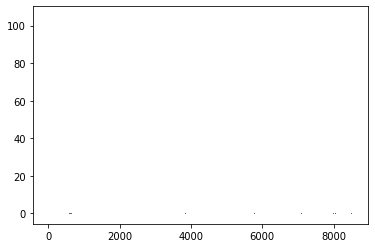

In [270]:
print(y[40000:].min())
plt.bar(range(len(y[40000:])),y[40000:])
plt.ylim()